# Run on Large Molecules
We have the solvation energies for a few dozen large molecules in different solvents. We are going to use them as a test set

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.benchmark import dielectric_constants, load_benchmark_data
from jcesr_ml.mpnn import set_custom_objects, run_model, GraphModel
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from scipy.stats import sem
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import os

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Using TensorFlow backend.
/home/wardlt/miniconda3/envs/solv_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wardlt/miniconda3/envs/solv_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wardlt/miniconda3/envs/solv_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wardlt/m

Model to evaluate

In [2]:
set_custom_objects()
model = load_model(os.path.join('..', 'mpnn', 'networks', 'dielectric-constant-softplus', '117232-entries',
                                '128-nodes', '16384-batch_size', '1.00e-04-learning_rate', 'best_model.h5'))
with open(os.path.join('..', 'mpnn', 'networks', 'dielectric-constant-softplus', 'converter.pkl'), 'rb') as fp:
    conv = pkl.load(fp)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/home/wardlt/miniconda3/envs/solv_ml/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Load in the Datasets
They are stored in our `data/output` directory

In [3]:
data = []
for name in ['sugar', 'hydrocarbon', 'nonsugars']:
    subset = pd.read_json(os.path.join('..', 'data', 'output', f'{name}_data.json'), lines=True)
    subset['source'] = name
    data.append(subset)
data = pd.concat(data, sort=False, ignore_index=True)

Add in the QM9 holdout set

In [4]:
train_data, test_data = load_benchmark_data()
test_data['source'] = 'QM9'
test_data.rename(columns={'smiles_0': 'smiles'}, inplace=True)
data = pd.concat((data, test_data), ignore_index=True, sort=False)

There is some overlap between the datasets

In [5]:
data.drop_duplicates('smiles', inplace=True)
print(f'Loaded {len(data)} unique molecules')

Loaded 13395 unique molecules


In [6]:
data['source'].value_counts()

QM9            13026
sugar            168
nonsugars        151
hydrocarbon       50
Name: source, dtype: int64

See how many have molecular motifs we have not yet observed.

We first change the tokenizers used in the preprocessor out of training mode, so 
that they will assign unseen motifs a label of `1`. 
This will result in the DL model using a randomly-initialized embedding for that atom or bond type,
in contrast to the learned embeddings for all other grops

In [7]:
conv.atom_tokenizer.train = conv.bond_tokenizer.train = False

In [8]:
def has_unseen_types(smiles: str) -> str:
    """Determine whether a molecule contains atom or bond types that
    were not included in the training set
    
    Args:
        smiles (str): SMILES string of a molecule
    Returns:
        (str) Label of whether it has new bonds or atom types
    """
    features = conv.construct_feature_matrices(smiles)
    
    new_atoms = any(features['atom'] == 1)
    new_bonds = any(features['bond'] == 1)
    
    if not (new_atoms or new_bonds):
        return 'none'
    elif new_atoms and not new_bonds:
        return 'atoms'
    elif not new_atoms and new_bonds:
        return 'bonds'
    else:
        return 'atoms+bonds'

In [9]:
data['unseen_types'] = data['smiles'].apply(has_unseen_types)

In [10]:
data['unseen_types'].value_counts()

none     13387
bonds        8
Name: unseen_types, dtype: int64

In [11]:
set(conv.bond_tokenizer.unknown)

{"(rdkit.Chem.rdchem.BondType.DOUBLE, True, False, ['N', 'N'])",
 "(rdkit.Chem.rdchem.BondType.SINGLE, False, False, ['F', 'N'])",
 "(rdkit.Chem.rdchem.BondType.SINGLE, False, False, ['N', 'N'])",
 "(rdkit.Chem.rdchem.BondType.SINGLE, False, False, ['O', 'O'])",
 "(rdkit.Chem.rdchem.BondType.SINGLE, True, False, ['N', 'N'])"}

*Finding*: 8 of our molecules have unseen bonding types, which include conjugated N=N bonds annd O-O single bonds.

## Evaluate Model on this Data
Run it for all solvents for which we have data for all solvents

In [12]:
sol_cols = [x for x in data.columns if x.startswith('sol_') and not data[x].isnull().any()]
print(f'Found {len(sol_cols)} solvation energy columns')

Found 3 solvation energy columns


Modify the converter to produce entries for these solvents

In [13]:
conv.dielectric_cnsts = [dielectric_constants[c] for c in sol_cols]

Run the model and store the errors

In [14]:
y_pred = run_model(model, conv, data['smiles'])

In [15]:
errors = (y_pred - data[sol_cols])
errors.rename(mapper=lambda x: x + '_error', axis=1, inplace=True)
err_cols = errors.columns
data = pd.concat((data, errors), axis=1)

Plot the total error histogram

Text(0.5, 0, 'Error (kcal/mol)')

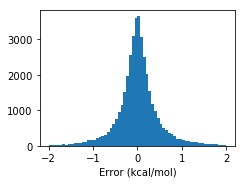

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.hist(np.ravel(data[err_cols]), bins=64, range=(-2, 2))

ax.set_xlabel('Error (kcal/mol)')

Break it down by source and size

In [17]:
def mean_abs_error(x):
    return np.abs(x).mean()
def mean_abs_error_sem(x):
    return sem(np.abs(x))
def mean_abs_deviation(x):
    return np.abs(x - np.mean(x)).mean()
funcs = [mean_abs_error, mean_abs_error_sem, len]

In [18]:
agg_funcs = dict((x, funcs) for x in err_cols)
agg_funcs.update(dict((x, [mean_abs_deviation, np.median]) for x in sol_cols))

In [19]:
data.groupby('source').agg(agg_funcs)

sol_acn_error                             sol_dmso_error  \
            mean_abs_error mean_abs_error_sem      len mean_abs_error   
source                                                                  
QM9               0.318080           0.004376  13026.0       0.319501   
hydrocarbon       0.691150           0.111962     50.0       2.194995   
nonsugars         1.102874           0.077701    151.0       2.439539   
sugar             1.651301           0.153793    168.0       1.480477   

                                        sol_water_error                     \
            mean_abs_error_sem      len  mean_abs_error mean_abs_error_sem   
source                                                                       
QM9                   0.004337  13026.0        0.436004           0.005662   
hydrocarbon           0.125077     50.0        0.614861           0.088479   
nonsugars             0.119621    151.0        1.100049           0.084004   
sugar                 0.137952    168.0        2.082375           0.207083   

                                sol_acn                    sol_dmso          \
                 len mean_abs_deviation   median mean_abs_deviation  median   
source                                                                        
QM9          13026.0           1.855499 -8.33175           2.049051 -7.1551   
hydrocarbon     50.0           1.188924 -5.23745           0.876097 -4.9482   
nonsugars      151.0           1.626477 -7.58860           1.584975 -7.2383   
sugar          168.0           2.109117 -7.22265           2.439686 -6.0908   

                     sol_water           
            mean_abs_deviation   median  
source                                   
QM9                   3.278651 -7.32150  
hydrocarbon           1.182210  1.67725  
nonsugars             2.413245 -2.06770  
sugar                 5.122572 -4.71770

In [20]:
data.groupby('n_heavy_atoms').agg(agg_funcs)

sol_acn_error                             sol_dmso_error  \
              mean_abs_error mean_abs_error_sem      len mean_abs_error   
n_heavy_atoms                                                             
2                   0.221154           0.153750      2.0       0.219060   
3                   0.590055           0.316760      5.0       0.551485   
4                   0.702498           0.198476     12.0       0.692357   
5                   0.309450           0.111036     26.0       0.304325   
6                   0.219064           0.054741     71.0       0.217395   
7                   0.207390           0.016557    350.0       0.213378   
8                   0.241335           0.008093   1827.0       0.244021   
9                   0.335438           0.005037  10834.0       0.336415   
10                  0.946924           0.114363    106.0       1.855250   
11                  1.193946           0.166562     57.0       2.236826   
12                  2.678680           0.263930     60.0       3.311073   
13                  2.218122           0.307608     28.0       3.565263   
14                  2.794387           0.276529     17.0       3.878207   

                                          sol_water_error                     \
              mean_abs_error_sem      len  mean_abs_error mean_abs_error_sem   
n_heavy_atoms                                                                  
2                       0.174665      2.0        0.181037           0.179816   
3                       0.312965      5.0        0.693895           0.408250   
4                       0.209982     12.0        0.871792           0.237136   
5                       0.097924     26.0        0.332576           0.140629   
6                       0.052007     71.0        0.281579           0.073250   
7                       0.016895    350.0        0.270570           0.020273   
8                       0.007908   1827.0        0.324371           0.010442   
9                       0.004996  10834.0        0.460965           0.006514   
10                      0.113034    106.0        1.193347           0.156252   
11                      0.136391     57.0        1.471779           0.229260   
12                      0.184525     60.0        3.356402           0.398198   
13                      0.337855     28.0        1.900908           0.350693   
14                      0.348980     17.0        2.160172           0.265138   

                                  sol_acn                    sol_dmso  \
                   len mean_abs_deviation   median mean_abs_deviation   
n_heavy_atoms                                                           
2                  2.0           0.343300 -2.26710           0.065250   
3                  5.0           0.794352 -3.89940           1.112544   
4                 12.0           0.940561 -4.24335           1.384992   
5                 26.0           1.594491 -5.20645           1.870290   
6                 71.0           1.398736 -5.92490           1.578738   
7                350.0           1.759617 -6.76885           1.986533   
8               1827.0           1.821869 -7.90090           2.015900   
9              10834.0           1.836696 -8.44740           2.037398   
10               106.0           1.787546 -6.76805           1.925458   
11                57.0           1.821995 -7.34170           1.809876   
12                60.0           2.160659 -8.44340           2.545555   
13                28.0           1.639456 -8.20960           1.698782   
14                17.0           0.714189 -9.38800           0.756409   

                                sol_water           
                median mean_abs_deviation   median  
n_heavy_atoms                                       
2             -2.10015           1.328550 -2.06415  
3             -3.79320           1.636816 -2.36210  
4             -3.95830           2.064228 -3.31340  
5             -4.29605           2.554527 -4.0

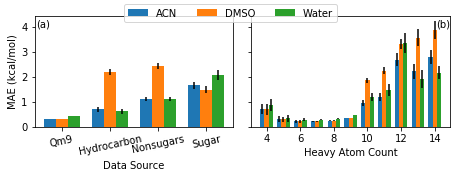

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5), sharey=True)

# Plot the dependence on source
analysis = data.groupby('source').agg(agg_funcs)
x = np.arange(len(analysis))
for i, c in enumerate(err_cols):
    mad = analysis[c[:-6]]['mean_abs_deviation']
    solvent = c.split("_")[1]
    axs[0].bar(x - 0.25 + i * 0.25, analysis[c]['mean_abs_error'], yerr=analysis[c]['mean_abs_error_sem'],
              width=0.25, align='center', label=solvent.capitalize() if solvent=='water' else solvent.upper())
axs[0].text(0.01, 0.9, '(a)', transform=axs[0].transAxes)
axs[0].set_xticks(x)
axs[0].set_xticklabels(analysis.index.str.capitalize(), rotation=12)
axs[0].set_xlabel('Data Source')

# Plot the atom count dependence
analysis = data.query('n_heavy_atoms > 3').groupby('n_heavy_atoms').agg(agg_funcs)
x = analysis.index.min() + np.arange(len(analysis))
for i, c in enumerate(err_cols):
    mad = analysis[c[:-6]]['mean_abs_deviation']
    axs[1].bar(x - 0.25 + i * 0.25, analysis[c]['mean_abs_error'], yerr=analysis[c]['mean_abs_error_sem'],
              width=0.25, align='center')
axs[1].set_xlabel('Heavy Atom Count')
axs[1].text(1, 0.9, '(b)', transform=axs[1].transAxes, ha='right')

fig.legend(ncol=3, loc='upper center')

axs[0].set_ylabel('MAE (kcal/mol)')

fig.tight_layout()
fig.savefig(os.path.join('figures', 'holdout-set-tests.png'), dpi=320)
fig.savefig(os.path.join('figures', 'holdout-set-tests.eps'))

## Compute Distance to Training Set
We want to compute the distance of each point in the test set to the nearest entries in the training 

In [22]:
rep_model = GraphModel(inputs=model.inputs, outputs=model.get_layer('reduce_atom_to_mol_5').output)

Compute the representations for the train and test sets

In [23]:
%%time
train_mols = run_model(rep_model, conv, train_data['smiles_0'], n_jobs=4)

CPU times: user 15min 18s, sys: 12min 53s, total: 28min 11s
Wall time: 12min 43s


In [24]:
%%time
test_mols = run_model(rep_model, conv, data['smiles'], n_jobs=4)

CPU times: user 1min 45s, sys: 1min 35s, total: 3min 21s
Wall time: 1min 39s


Make the nearest neighbor computer on a reduced space

In [ ]:
n_counts = [1, 2, 4, 8, 16, 32, 64]
for n in tqdm(n_counts):
    dim_reduction = Pipeline([
        ('scale', MinMaxScaler()),
        ('pca', PCA(128)),
    ])
    nn_computer = NearestNeighbors(n_neighbors=n, n_jobs=-1).fit(dim_reduction.fit_transform(train_mols))

    data[f'train_dist_{n}'] = nn_computer.kneighbors(dim_reduction.transform(test_mols))[0].mean(axis=1)

 57%|█████▋    | 4/7 [06:21<04:45, 95.14s/it]

Plot the dependence of error on distance

Text(0, 0.5, 'Mean Error (kcal/mol)')

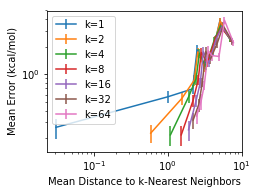

In [30]:
fig, ax = plt.subplots(figsize=(3.5, 2.6))

data['total_error'] = data[err_cols].abs().mean(axis=1)
for n in n_counts:
    dist_col = f'train_dist_{n}'
    dist_mean, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), np.mean(s['total_error']), sem(s['total_error'])) 
                                           for s in np.array_split(data.query('source != "QM9"').sort_values(dist_col), 8)])

    ax.errorbar(dist_mean, err_mean, yerr=err_sem, label=f'k={n}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Mean Distance to k-Nearest Neighbors')
ax.set_ylabel('Mean Error (kcal/mol)')

*Finding*: The relationship between distance and error seems clearest for k=64

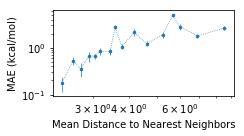

In [31]:
fig, ax = plt.subplots(figsize=(3.5, 2))

data['total_error'] = data[err_cols].abs().mean(axis=1)
n=64
dist_col = f'train_dist_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['total_error']), sem(s['total_error'])) 
                                       for s in np.array_split(data.query('source != "QM9"').sort_values(dist_col), 16)])

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=f'k={n}', marker='o', markersize=2.5
            , linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Mean Distance to Nearest Neighbors')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-distance.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-distance.eps'))

*Finding*: There is indeed a clear relationship between MAE and the distance to the training set even for the larger molecules

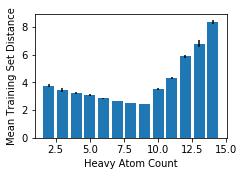

In [32]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

distances = data.groupby('n_heavy_atoms')['train_dist_64'].agg([np.mean, sem])

ax.bar(distances.index, distances['mean'], yerr=distances['sem'])

ax.set_xlabel('Heavy Atom Count')
ax.set_ylabel('Mean Training Set Distance')
fig.tight_layout()